In [4]:
!pip install osmnx

In [6]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [22]:
df=pd.read_csv("/content/data_stores.csv")

In [23]:
df.head(5)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [24]:
city = "London"
df=df[df["City"]==city][["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
df=df.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(df))
df.head(5)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23
3,3,London,1442 Fanshawe Park Road,43.01,-81.34
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26


In [25]:
data=df.copy()
data["color"]=''
data.loc[data["id"]==0, 'color'] = 'red'
data.loc[data["id"]!=0, 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(5)
print("starting point:", start)

starting point: [ 42.99 -81.26]


In [26]:
map = folium.Map(location=start, tiles="cartodb positron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
               location=[row["y"], row["x"]],
               radius=5,
               color=row["color"],
               fill=True,
               fill_color=row["color"]
           ).add_to(map), axis=1
           )
map

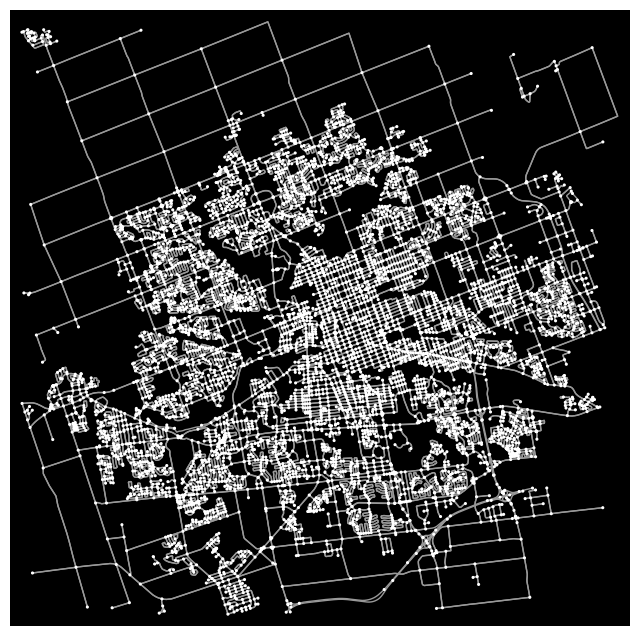

In [27]:
G=ox.graph_from_point(start, dist=10000, network_type='drive')
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax=ox.plot_graph(G,bgcolor="black", node_size=5,node_color="white", figsize=(16,8))

In [28]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
df["node"]=df[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
df=df.drop_duplicates("node", keep='first')
df.head()

<ipython-input-28-bff48584b634>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["node"]=df[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-28-bff48584b634>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["node"]=df[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-28-bff48584b634>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["node"]=

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [29]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in df["node"].tolist()] for a in df["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=df["node"].values, index=df["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.000000,562.851249,353.033842,594.714108,498.751340,403.383493,126.539199,393.757943,554.838587,101.814225,514.110793,435.283193,233.317315,198.972646,567.058682,226.213208,522.833978,477.120524,1034.605763,1046.943123
324811692,590.173713,0.000000,210.854993,1099.747770,950.660107,713.170050,458.117936,871.444296,736.598336,489.691198,402.678162,890.405124,670.107103,403.241314,680.639750,777.472659,119.618465,982.154186,1311.267733,782.598394
11756886360,379.318720,209.817407,0.000000,913.372457,739.805114,579.108572,247.262943,660.589303,550.223024,278.836205,412.448535,704.029811,459.252109,192.386321,582.559548,579.268279,239.871639,795.778873,1201.612905,914.944568
252974916,592.990749,1096.634969,915.099164,0.000000,428.963535,858.419764,704.875681,323.970139,481.424322,665.851819,725.879492,356.000709,500.976725,764.563816,1083.536137,433.001886,1026.210962,174.879255,1306.519779,979.676444
302754873,498.674427,951.676786,741.859379,430.044476,0.000000,480.695121,573.152526,107.363877,892.105864,513.646840,865.095683,764.822150,348.771747,568.959327,705.811494,395.047471,981.460914,312.450893,928.795135,1390.357986


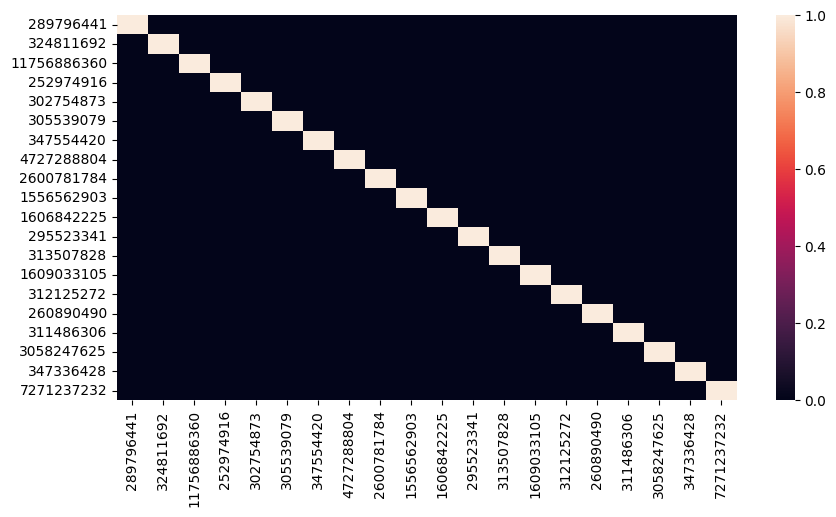

In [30]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , ax=ax)
plt.show()

In [31]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,563,353,595,499,403,127,394,555,102,514,435,233,199,567,226,523,477,1035,1047
324811692,590,0,211,1100,951,713,458,871,737,490,403,890,670,403,681,777,120,982,1311,783
11756886360,379,210,0,913,740,579,247,661,550,279,412,704,459,192,583,579,240,796,1202,915
252974916,593,1097,915,0,429,858,705,324,481,666,726,356,501,765,1084,433,1026,175,1307,980
302754873,499,952,742,430,0,481,573,107,892,514,865,765,349,569,706,395,981,312,929,1390


In [32]:
drivers = 1
lst_nodes= df["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [33]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [34]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [35]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.69km
Nodes visited: 20


In [36]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [37]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

map = folium.Map(location=start, tiles="cartodb positron", zoom_start=12)
data.apply(lambda row: folium.CircleMarker(
    location=[row["y"], row["x"]],
    radius=5,
    color=row["color"],
    fill=True,
    fill_color=row["color"]
).add_to(map), axis=1)


for path in lst_paths:
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(route_coords, color="blue", weight=3, opacity=0.7).add_to(map)

map

In [38]:
 def dtf_animation_multiple_path(G, lst_paths, parallel=True):
    dtf=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        dtf=pd.concat([dtf,tmp], ignore_index=(not parallel))

    dtf=dtf.reset_index().rename(columns={"index":"id"})
    return dtf

In [39]:
dtf= pd.DataFrame()
tmp=dtf_animation_multiple_path(G, lst_paths, parallel=False)
dtf=pd.concat([dtf, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [40]:
dtf

,id,start,end,start_x,start_y,end_x,end_y,length,travel_time
0,0,289796441,293557419,-81.260399,42.989256,-81.258445,42.989189,159,11
1,1,293557419,12120514859,-81.258445,42.989189,-81.256653,42.988821,152,16
2,2,12120514859,12120514837,-81.256653,42.988821,-81.256557,42.988542,32,6
3,3,12120514837,12120514844,-81.256557,42.988542,-81.256466,42.988375,33,3
4,4,12120514844,12120514831,-81.256466,42.988375,-81.256294,42.988247,20,4
...,...,...,...,...,...,...,...,...,...
994,994,300391230,266052927,-81.323562,42.904844,-81.332640,42.909411,909,41
995,995,266052927,300182337,-81.332640,42.909411,-81.337015,42.912233,475,21
996,996,300182337,254524172,-81.337015,42.912233,-81.342737,42.915418,590,27
997,997,254524172,1571564446,-81.342737,42.915418,-81.359672,42.914564,1390,63


In [41]:
dtf_start= dtf[dtf["start"]== first_node]
dtf_end=dtf[dtf["end"]== last_node]

fig=px.scatter_mapbox(data_frame=dtf, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=df, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=dtf_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=dtf_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=dtf, lon="start_x", lat="start_y").data[0])

fig